# Example: EDI-Vetter Unplugged tool for WASP 18b
## (~0.94 day Period, ~13 Earth Radii Radius)

Begin by importing the necessary packages. This tutorial was written by [Dax Feliz](https://daxfeliz.github.io) and was meant to run independently. Thus, it includes all the steps needed to download the light curve data, search for a transit signal, and finally vet the detected signal. 

In [1]:
import EDIunplugged as EDI
import lightkurve as lk

import os,sys
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
pd.set_option('display.notebook_repr_html', True)

#pipeline settings
path=os.getcwd()+'/'

Here, we will import the TESS PDCSAP flux data using lightkurve.

In [2]:
import lightkurve as lk
lk.log.setLevel('INFO')

ID=100100827; Sector=2

#save to local directory
downloadpath=os.getcwd()+'/'

target='TIC '+str(ID)
lc_2min=lk.search.search_lightcurvefile(target, cadence='short', mission=("TESS"),sector=Sector).download(download_dir=downloadpath)
lc_2min_precut=lc_2min.PDCSAP_FLUX.remove_nans().normalize()

7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


To make sure we have a nice clear light curve we will apply a quality mask, removing data that has been flagged as problematic, then plot the resulting light curve.

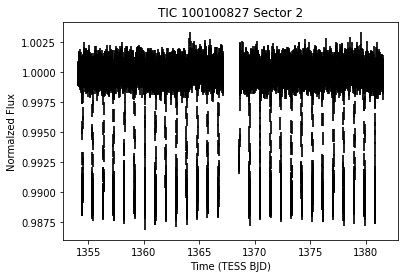

In [3]:
q = lc_2min_precut.quality!=0
lc_2min = lk.LightCurve(time=lc_2min_precut.time[~q],flux=lc_2min_precut.flux[~q],flux_err=lc_2min_precut.flux_err[~q])

#plot
plt.errorbar(x=lc_2min_precut.time,y=lc_2min_precut.flux,yerr=lc_2min_precut.flux_err,color='grey',linestyle='none')
plt.errorbar(x=lc_2min.time,y=lc_2min.flux,yerr=lc_2min.flux_err,color='black',linestyle='none')
plt.xlabel('Time (TESS BJD)')
plt.ylabel('Normalzed Flux')
plt.title('TIC '+str(ID)+' Sector '+str(Sector))
plt.show()

Save the output to a CSV file

In [4]:
#saving in current working directory
input_LC = pd.DataFrame({'Time':lc_2min.time, 'SAP Flux':lc_2min.flux, 'SAP Error':lc_2min.flux_err})
input_LC.to_csv(os.getcwd()+'/TIC_'+str(ID)+'_Sector_'+str(Sector)+'_SPOC_LC.csv')


Pull stellar paramters from TIC using TLS

In [5]:
from transitleastsquares import catalog_info    
qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)


Use the stellar parameters and flux data to run a TLS search for the highest power signal.

In [6]:
known_period = 0.94124 #WASP 18b
known_period2 = 2.1558 #WASP 18c

time=input_LC['Time']
flux=input_LC['SAP Flux']
error=input_LC['SAP Error']

from transitleastsquares import transitleastsquares

#input parameters
N_transits=3
minP=0.5

tls = transitleastsquares(time,flux,error)

tls_power = tls.power(R_star_min=R_star-R_star_min, R_star_max=R_star+R_star_max,R_star=R_star,\
                                  M_star_min=M_star-M_star_min, M_star_max=M_star+M_star_max, M_star=M_star,\
                                  u=qld, period_min=minP)



  0%|          | 0/1634 periods | 00:00<?

Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 28 durations
Searching 18316 data points, 1634 periods from 0.858 to 13.702 days
Using all 8 CPU threads


100%|██████████| 1634/1634 periods | 00:06<00:00


We can now fold the light curve according to the TLS search period (0.941074790293308 days) and visualize the resulting transit signal.

 
TIC 100100827 Sector 2
Period: 0.941074790293308
Transit Count:  29


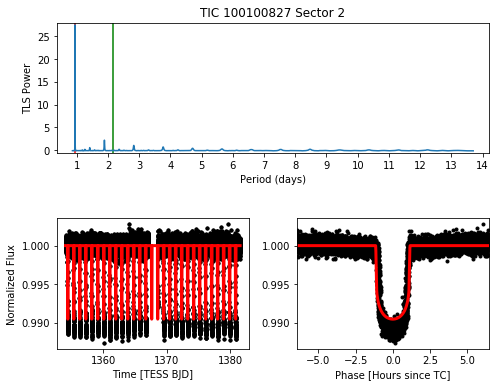

In [7]:
print(' ')
print('TIC '+str(ID)+' Sector '+str(Sector))
print('Period: '+str(tls_power.period))
print('Transit Count: ',tls_power.transit_count)


def phasefold(T0,time,period,flux):
    phase=(time- T0 + 0.5*period) % period - 0.5*period        
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]


ModelT=tls_power.model_lightcurve_time 
ModelF=tls_power.model_lightcurve_model

#phase folding LC and TLS model
pf,ff  = phasefold(tls_power.T0, time, tls_power.period,flux)
pf_model,ff_model = phasefold(ModelT,tls_power.T0,tls_power.period,ModelF)

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)
###
###
fig = plt.figure(figsize=(10,6))        
ax1 = fig.add_subplot(gs1[0:1, 0:2])
ax2 = fig.add_subplot(gs1[1:, 0:1])
ax3 = fig.add_subplot(gs1[1:, 1:2])


ax1.plot(tls_power.periods, tls_power.power, rasterized=True)
ax1.axvline(x=known_period,color='red',zorder=-1)
ax1.axvline(x=known_period2,color='green',zorder=-1)
ax1.set_title("TIC "+str(ID)+" "+"Sector "+str(Sector))#" Camera "+Camera+" CCD "+CCD)
ax1.set_xlabel("Period (days)")
ax1.set_xticks(np.arange(0.0, 15.0, 1.0))
ax1.set_xlim(np.min(tls_power.periods)-0.5, np.max(tls_power.periods)+0.5)
###
ax1.set_ylabel("TLS Power")
ax1.set_ylim(np.min(tls_power.power)-0.5, np.max(tls_power.power)+0.5)

ax2.plot(time,flux,'k.')
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Time [TESS BJD]')
ax2.plot(time,flux,'k.')
ax2.plot(ModelT,ModelF,'r-',linewidth=3)

ax3.plot(24*pf,ff,'k.')
ax3.plot(24*pf_model,ff_model,'r-',linewidth=3)
ax3.set_xlim(-3*24*tls_power.duration,3*24*tls_power.duration)
ax3.set_xlabel('Phase [Hours since TC]')
fig.savefig('TIC_'+str(ID)+'_Sector_'+str(Sector)+'_SPOC_TLS_result.png',bbox_inches='tight')
fig.show()



## Running EDI-Vetter unplugged

Upon visual inspection, this signal looks real. We should, therefore, expect the EDI-Vetter unplugged to produce a negative false positive classification. Let's now run it and see.

In [8]:
params=EDI.parameters(tls_power, limbDark=[qld[0], qld[1]], impact=0, snrThreshold=6, minTransit=N_transits)
params=EDI.Go(params, telescope='TESS')


 ___________ _____      _   _      _   _
|  ___|  _  \_   _|    | | | |    | | | |
| |__ | | | | | |______| | | | ___| |_| |_ ___ _ __
|  __|| | | | | |______| | | |/ _ \ __| __/ _ \ '__|
| |___| |/ / _| |_     \ \_/ /  __/ |_| ||  __/ |
\____/|___/  \___/      \___/ \___|\__|\__\___|_|   Unplugged
    
Version 0.1.2 (11 Sept 2020)
            Vetting Report
        Flux Contamination : False
         Too Many Outliers : False
  Too Many Transits Masked : False
Odd/Even Transit Variation : False
      Signal is not Unique : False
   Secondary Eclipse Found : False
Low Transit Phase Coverage : False
 Transit Duration Too Long : False
Signal is a False Positive : False


As suspected, this clear transit singal passes all the metrics and EDI-Vetter unplugged is able to identifiy this signal correctly.